<a href="https://colab.research.google.com/github/Kameneses/transfer-learning-class/blob/main/notebooks/transfer_learning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline


Transfer Learning for Computer Vision 
==============================================


Estos dos grandes escenarios de aprendizaje por transferencia son los siguientes:

- **Inicialización de la convnet**: En lugar de una inicialización aleatoria
   inicializamos la red con una red preentrenada, como la que se
   entrenada en el conjunto de datos imagenet.
- **ConvNet como extractor de características fijo**: Aquí, vamos a congelar los pesos para toda la red excepto la de la capa final totalmente conectada totalmente conectada. Esta última capa totalmente conectada se sustituye por una nueva con pesos aleatorios y sólo se entrena esta capa.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

Utilizaremos los paquetes `torchvision` y `torch.utils.data` para cargar los
datos.

El problema que vamos a resolver es entrenar un modelo para clasificar
**hormigas** y **abejas**. Tenemos unas 120 imágenes de entrenamiento para hormigas y abejas.
Hay 75 imágenes de validación para cada clase. Normalmente, este es un conjunto de datos muy pequeño para generalizar, si se entrena desde cero. 

Dado que estamos utilizando el aprendizaje por transferencia, deberíamos ser capaces de generalizar razonablemente bien.



> Note :: Descargar los datos de [aquí](https://download.pytorch.org/tutorial/hymenoptera_data.zip).


   



In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip && unzip hymenoptera_data.zip

--2021-11-14 10:12:32--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.230.19.122, 54.230.19.15, 54.230.19.35, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.230.19.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   149MB/s    in 0.3s    

2021-11-14 10:12:32 (149 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/t

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Visualicemos algunas imágenes de entrenamiento para entender los datos
aumentos de datos.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


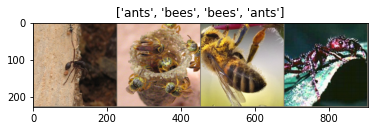

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Ahora vamos a escribir una función para entrenar el modelo.



In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Función para mostrar los resultados del modelo



In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Cargamos un modelo preentrenado y configuramos métrica, optimizador y learning rate




In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]


Realizamos el entrenamiento. Podemos comprobar la diferente velocidad de entrenamiento si lo ejecutamos en entorno CPU o GPU.

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5390 Acc: 0.7213
val Loss: 0.2742 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.4857 Acc: 0.8115
val Loss: 0.2923 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.6222 Acc: 0.7623
val Loss: 0.2688 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.6662 Acc: 0.7664
val Loss: 0.6740 Acc: 0.7320

Epoch 4/24
----------
train Loss: 0.8577 Acc: 0.7336
val Loss: 0.3611 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.5330 Acc: 0.8320
val Loss: 0.5014 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.6757 Acc: 0.7746
val Loss: 0.2731 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.4553 Acc: 0.8033
val Loss: 0.2561 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.4382 Acc: 0.7992
val Loss: 0.2566 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.3251 Acc: 0.8525
val Loss: 0.2301 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3484 Acc: 0.8361
val Loss: 0.2309 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3231 Acc: 0.8689
val Loss: 0.2415 Acc: 0.8889

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


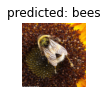

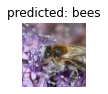

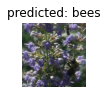

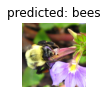

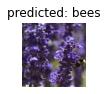

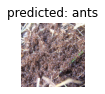

In [10]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------
Ahora vamos a congelar toda la red exceptuando la última capa densa. Necesitamos configurar ``requires_grad == False `` para congelar los parametros. 

Puedes leer más [aquí](https:https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)






In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Al haber congelado la mayor parte de los parametros de la red podemos comprobar que el entrenamiento es mucho más veloz tanto en CPU como GPU





In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.8391 Acc: 0.5861
val Loss: 0.3200 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.5597 Acc: 0.7500
val Loss: 0.2042 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4071 Acc: 0.8156
val Loss: 0.1929 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.6897 Acc: 0.7500
val Loss: 0.2279 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4696 Acc: 0.8238
val Loss: 0.2221 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.5002 Acc: 0.7541
val Loss: 0.2171 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4659 Acc: 0.8238
val Loss: 0.2010 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3522 Acc: 0.8361
val Loss: 0.1882 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.4154 Acc: 0.8484
val Loss: 0.1998 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3663 Acc: 0.8443
val Loss: 0.2055 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3234 Acc: 0.8566
val Loss: 0.2079 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3389 Acc: 0.8525
val Loss: 0.2056 Acc: 0.9412

Epoch 12/24
----------
t

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


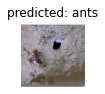

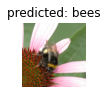

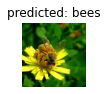

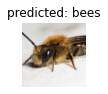

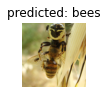

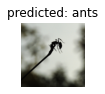

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()